Test de la méthode VAE (Question 7)
Génération des données d'entraînement pour le VAE...
Génération des données: 100/1000
Génération des données: 200/1000
Génération des données: 300/1000
Génération des données: 400/1000
Génération des données: 500/1000
Génération des données: 600/1000
Génération des données: 700/1000
Génération des données: 800/1000
Génération des données: 900/1000
Génération des données: 1000/1000
Données générées: u_data_train shape: torch.Size([1000, 100])
Utilisation du device: cpu
Modèle VAE créé. Début de l'entraînement...
Début de l'entraînement pour 50 époques...
Epoch [5/50], Loss: -0.1679, Recon Loss: 0.4344, Reg Loss: -0.6023
Epoch [10/50], Loss: -0.5852, Recon Loss: 0.1777, Reg Loss: -0.7629
Epoch [15/50], Loss: -0.6142, Recon Loss: 0.1517, Reg Loss: -0.7660
Epoch [20/50], Loss: -0.6371, Recon Loss: 0.1295, Reg Loss: -0.7666
Epoch [25/50], Loss: -0.6444, Recon Loss: 0.1225, Reg Loss: -0.7669
Epoch [30/50], Loss: -0.6505, Recon Loss: 0.1164, Reg Loss: -0.76

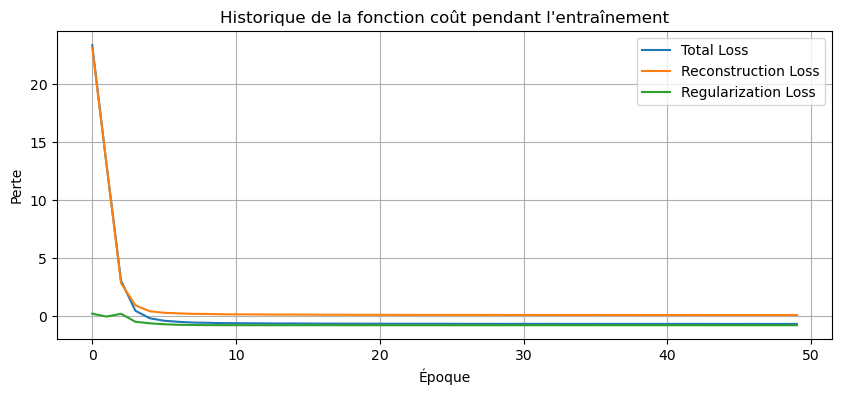

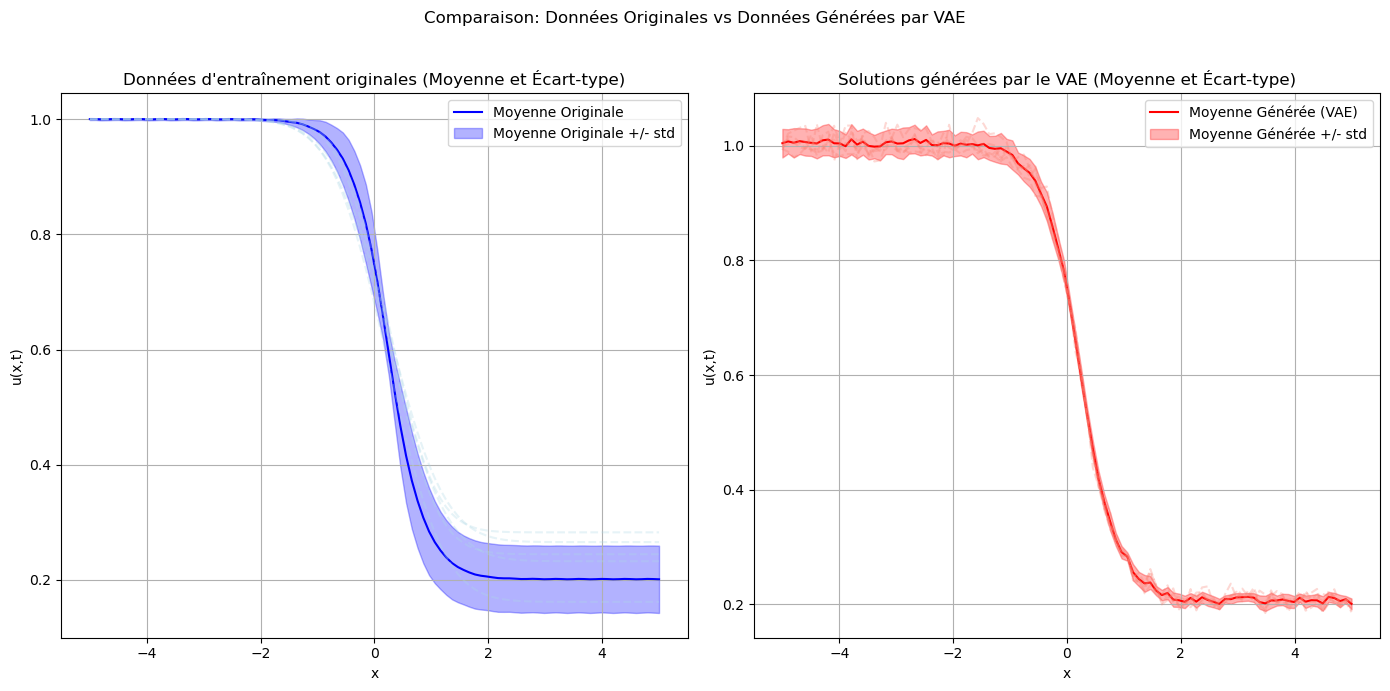

Test de la méthode VAE terminé.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# --- Question 1: Solution de l'équation de Burgers ---
def solution_Burgers_visqueux(x_tensor, t, uL, uR, nu):
    """
    Calcule la solution exacte de l'équation de Burgers visqueux.

    Args:
        x_tensor (torch.Tensor): Tensor des points x (taille (nx)).
        t (float): Temps t.
        uL (float): Valeur de u à gauche.
        uR (float): Valeur de u à droite.
        nu (float): Viscosité.

    Returns:
        torch.Tensor: Solution u évaluée aux points x (taille (nx)).
    """
    nx = x_tensor.shape[0]
    y_eval = torch.linspace(-20, 20, 100, device=x_tensor.device, dtype=x_tensor.dtype) # Points d'intégration
    dy = y_eval[1] - y_eval[0]

    # G(y) = intégrale de u(0,z)dz de 0 à y
    # u(0,z) = uL si z <= 0, uR si z > 0
    G_y = torch.zeros_like(y_eval)
    G_y[y_eval <= 0] = uL * y_eval[y_eval <= 0]
    G_y[y_eval > 0] = uR * y_eval[y_eval > 0]

    # Pour chaque point x, on calcule les intégrales
    u_solution = torch.zeros_like(x_tensor)

    for i in range(nx):
        x_val = x_tensor[i]
        
        # Terme dans l'exponentielle pour l'intégration
        exp_term_common = -((x_val - y_eval)**2) / (4 * nu * t) - G_y / (2 * nu)
        
        # Intégrale du numérateur
        integrand_num = ((x_val - y_eval) / t) * torch.exp(exp_term_common)
        integral_num = torch.sum(integrand_num * dy)
        
        # Intégrale du dénominateur
        integrand_den = torch.exp(exp_term_common)
        integral_den = torch.sum(integrand_den * dy)
        
        if torch.abs(integral_den) < 1e-9: # Éviter la division par zéro
             # Comportement si le dénominateur est trop petit, peut indiquer un problème ou des paramètres extrêmes
             # Pour Burgers, si nu*t est très petit, la solution est proche d'une onde de choc.
             # Si les exponentielles sont toutes nulles (underflow), cela peut arriver.
             # Une solution simple est de prendre la moyenne de uL et uR, ou de signaler une erreur.
             # Ici, nous allons simplement mettre 0, mais cela pourrait nécessiter une gestion plus fine.
            u_solution[i] = 0.0 
        else:
            u_solution[i] = integral_num / integral_den
            
    return u_solution

def test_solution_burgers():
    print("Test de solution_Burgers_visqueux:")
    x = torch.linspace(-5, 5, 100)
    t = 0.4
    uL = 1.0
    uR = 0.2
    nu = 0.1
    u = solution_Burgers_visqueux(x, t, uL, uR, nu)
    
    plt.figure()
    plt.plot(x.numpy(), u.numpy())
    plt.title(f"Solution de Burgers (uL={uL}, uR={uR}, nu={nu}, t={t})")
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.grid(True)
    plt.show()
    print("Solution testée.\n")

# --- Question 2: Génération de données ---
def generate_data(nb_data, nx, t_eval):
    """
    Génère un ensemble de données de solutions de Burgers.

    Args:
        nb_data (int): Nombre de solutions à générer.
        nx (int): Nombre de points dans le maillage spatial.
        t_eval (float): Temps d'évaluation de la solution.

    Returns:
        Tuple: (uL_params, uR_params, nu_params, xmesh, u_data)
               uL_params (torch.Tensor): Tensor des uL (taille (nb_data)).
               uR_params (torch.Tensor): Tensor des uR (taille (nb_data)).
               nu_params (torch.Tensor): Tensor des nu (taille (nb_data)).
               xmesh (torch.Tensor): Maillage spatial x (taille (nx)).
               u_data (torch.Tensor): Solutions u (taille (nb_data, nx)).
    """
    uL_fixed = 1.0
    
    # Échantillonnage des paramètres
    uR_params = torch.rand(nb_data) * (0.3 - 0.1) + 0.1  # Uniforme sur [0.1, 0.3]
    nu_params = torch.rand(nb_data) * (1.0 - 0.05) + 0.05 # Uniforme sur [0.05, 1.0]
    uL_params = torch.full((nb_data,), uL_fixed)

    xmesh = torch.linspace(-5, 5, nx)
    u_data = torch.zeros((nb_data, nx))

    for i in range(nb_data):
        if (i+1) % (nb_data//10 if nb_data >=10 else 1) == 0:
            print(f"Génération des données: {i+1}/{nb_data}")
        u_data[i, :] = solution_Burgers_visqueux(xmesh, t_eval, uL_fixed, uR_params[i].item(), nu_params[i].item())
        
    return uL_params, uR_params, nu_params, xmesh, u_data

def test_generate_data():
    print("Test de generate_data:")
    nb_data = 100 # Réduire pour un test rapide si besoin
    nx = 200
    t = 0.4
    
    _, _, _, xmesh, u_data = generate_data(nb_data, nx, t)
    
    mean_solution = torch.mean(u_data, dim=0)
    variance_solution = torch.var(u_data, dim=0)
    std_solution = torch.sqrt(variance_solution)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xmesh.numpy(), mean_solution.numpy(), label="Moyenne des solutions")
    plt.fill_between(xmesh.numpy(), 
                     (mean_solution - std_solution).numpy(), 
                     (mean_solution + std_solution).numpy(), 
                     alpha=0.3, label="Moyenne +/- std")
    plt.title("Moyenne et écart-type des solutions générées")
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    # Afficher quelques solutions individuelles
    for i in range(min(nb_data, 5)):
         plt.plot(xmesh.numpy(), u_data[i].numpy(), alpha=0.5)
    plt.title("Quelques solutions générées")
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    print("Données de test générées et visualisées.\n")
    return xmesh, u_data


# --- Question 3 & 4 & 5 & 6: Classe Vae ---
class Vae(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims_enc=[64, 32, 16], hidden_dims_dec=[16, 32, 64], lr=1e-3):
        super(Vae, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        encoder_layers = []
        current_dim = input_dim
        for h_dim in hidden_dims_enc:
            encoder_layers.append(nn.Linear(current_dim, h_dim))
            encoder_layers.append(nn.ReLU())
            current_dim = h_dim
        self.encoder_body = nn.Sequential(*encoder_layers)
        self.fc_mu = nn.Linear(current_dim, latent_dim)       # Pour la moyenne
        self.fc_log_std = nn.Linear(current_dim, latent_dim)  # Pour le log de l'écart-type

        # Decoder
        decoder_layers = []
        current_dim = latent_dim
        for h_dim in hidden_dims_dec:
            decoder_layers.append(nn.Linear(current_dim, h_dim))
            decoder_layers.append(nn.ReLU())
            current_dim = h_dim
        decoder_layers.append(nn.Linear(current_dim, input_dim))
        # Pas d'activation finale pour la reconstruction (mu_theta)
        self.decoder = nn.Sequential(*decoder_layers)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def encode(self, x):
        h = self.encoder_body(x)
        mu = self.fc_mu(h)
        log_std = self.fc_log_std(h) # log(sigma_phi(x))
        return mu, log_std

    def sampling(self, mu, log_std): # log_std est log(sigma_phi(x))
        std = torch.exp(log_std)  # sigma_phi(x)
        eps = torch.randn_like(std) # Epsilon de N(0, Id)
        return mu + std * eps       # z = mu + sigma * epsilon

    def decode(self, z):
        return self.decoder(z) # mu_theta

    def forward(self, x):
        mu_phi, log_std_phi = self.encode(x)
        z = self.sampling(mu_phi, log_std_phi)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mu_phi, log_std_phi

    # Question 5: Renommée en generate_samples_from_prior pour clarté
    def generate_samples_from_prior(self, nb_samples, device='cpu'):
        """ Génère des échantillons à partir de la loi a priori p(z) = N(0,Id) et applique le décodeur. """
        self.eval() # Mode évaluation
        with torch.no_grad():
            # Échantillonner z de la loi a priori N(0, Id)
            z_prior = torch.randn(nb_samples, self.latent_dim, device=device)
            # Appliquer le décodeur pour générer des données dans l'espace d'entrée
            generated_data = self.decode(z_prior)
        return generated_data

    # Question 6: Méthode d'entraînement
    def training_step(self, data_batch):
        self.train() # Mode entraînement
        self.optimizer.zero_grad()
        
        reconstructed_x, mu_phi, log_std_phi = self.forward(data_batch)
        
        # Calcul de la perte ELBO telle que définie dans l'énoncé
        # ELBO(theta,phi) = 0.5 * sum_i ||xi - mu_theta(z_i)||^2 
        #                   + 0.5 * sum_i (sigma_phi^2(xi) - 1 + ||mu_phi(xi)||^2 - log sigma_phi(xi))
        # Note: sum_i est sur le batch. ||.||^2 est somme des carrés des éléments.
        # log sigma_phi(xi) est log_std_phi
        # sigma_phi^2(xi) est exp(log_std_phi)^2 = exp(2 * log_std_phi)

        # Terme de reconstruction (moyenné sur le batch et les dimensions de l'input)
        # L'énoncé dit 0.5 * sum_i || ... ||^2.
        # F.mse_loss(reconstructed_x, data_batch, reduction='sum') calcule sum_dims sum_batch (x_rec - x)^2
        # Donc, on divise par la taille du batch pour avoir une moyenne par échantillon du batch
        # Si on veut une somme sur le batch, on utilise reduction='sum'.
        # Pour la stabilité, on moyenne souvent sur le batch.
        # Si on prend la somme sur les éléments du batch (sum_i), et que ||.||^2 est la somme sur les dimensions de x_i:
        reconstruction_loss = 0.5 * F.mse_loss(reconstructed_x, data_batch, reduction='none').sum(dim=1).sum()
        
        # Terme de régularisation (KL-like)
        # sum_i ( sigma^2 - 1 + mu^2 - log_sigma )
        # sigma = exp(log_std_phi)
        # sigma^2 = exp(2 * log_std_phi)
        # mu^2 est la somme des carrés des composantes de mu_phi
        # log_sigma est log_std_phi
        # Somme sur les dimensions latentes, puis somme sur le batch
        term_reg = torch.exp(2 * log_std_phi) - 1 + mu_phi.pow(2) - log_std_phi
        regularization_loss = 0.5 * term_reg.sum(dim=1).sum() # Somme sur latent_dim, puis somme sur batch

        total_loss = (reconstruction_loss + regularization_loss) / data_batch.size(0) # Moyenne sur le batch
        
        total_loss.backward()
        self.optimizer.step()
        
        return total_loss.item(), reconstruction_loss.item() / data_batch.size(0), regularization_loss.item() / data_batch.size(0)

    def train_vae(self, train_data, epochs=100, batch_size=32):
        train_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(train_data),
            batch_size=batch_size,
            shuffle=True
        )
        
        history = {'total_loss': [], 'recon_loss': [], 'reg_loss': []}
        print(f"Début de l'entraînement pour {epochs} époques...")
        for epoch in range(epochs):
            epoch_total_loss = 0
            epoch_recon_loss = 0
            epoch_reg_loss = 0
            num_batches = 0
            for (batch_data,) in train_loader: # batch_data est un tuple, on extrait le tenseur
                loss, recon, reg = self.training_step(batch_data)
                epoch_total_loss += loss
                epoch_recon_loss += recon
                epoch_reg_loss += reg
                num_batches +=1
            
            avg_total_loss = epoch_total_loss / num_batches
            avg_recon_loss = epoch_recon_loss / num_batches
            avg_reg_loss = epoch_reg_loss / num_batches
            
            history['total_loss'].append(avg_total_loss)
            history['recon_loss'].append(avg_recon_loss)
            history['reg_loss'].append(avg_reg_loss)

            if (epoch + 1) % (epochs // 10 if epochs >=10 else 1) == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_total_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, Reg Loss: {avg_reg_loss:.4f}")
        
        print("Entraînement terminé.")
        
        # Plot training history
        plt.figure(figsize=(10, 4))
        plt.plot(history['total_loss'], label='Total Loss')
        plt.plot(history['recon_loss'], label='Reconstruction Loss')
        plt.plot(history['reg_loss'], label='Regularization Loss')
        plt.title('Historique de la fonction coût pendant l\'entraînement')
        plt.xlabel('Époque')
        plt.ylabel('Perte')
        plt.legend()
        plt.grid(True)
        plt.show()


# --- Question 7: Test de la méthode VAE ---
def test_vae_method():
    print("Test de la méthode VAE (Question 7)")
    
    # Paramètres
    nb_data_train = 1000 # Augmenter pour de meilleurs résultats (ex: 5000-10000)
    nx = 100             # Dimension de l'input du VAE
    t_eval = 0.4
    latent_dim = 10      # Dimension de l'espace latent (à ajuster)
    epochs = 50          # Augmenter pour un meilleur entraînement (ex: 200-500)
    batch_size = 64

    # 1. Générer les données d'entraînement (similaire à la Question 2)
    print("Génération des données d'entraînement pour le VAE...")
    _, _, _, xmesh_train, u_data_train = generate_data(nb_data_train, nx, t_eval)
    print(f"Données générées: u_data_train shape: {u_data_train.shape}")

    # 2. Initialiser et entraîner le VAE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Utilisation du device: {device}")

    u_data_train = u_data_train.to(device)
    
    vae_model = Vae(input_dim=nx, latent_dim=latent_dim).to(device)
    print("Modèle VAE créé. Début de l'entraînement...")
    vae_model.train_vae(u_data_train, epochs=epochs, batch_size=batch_size)

    # 3. Utiliser la fonction generate_samples_from_prior (Q5) et reproduire le graphique de la Q2
    nb_samples_generated = 500 # Nombre d'échantillons à générer depuis le VAE
    generated_solutions = vae_model.generate_samples_from_prior(nb_samples_generated, device=device)
    generated_solutions = generated_solutions.cpu() # Ramener sur CPU pour numpy/matplotlib

    mean_generated = torch.mean(generated_solutions, dim=0)
    variance_generated = torch.var(generated_solutions, dim=0)
    std_generated = torch.sqrt(variance_generated)

    # Comparaison avec les données originales
    mean_original = torch.mean(u_data_train.cpu(), dim=0)
    std_original = torch.std(u_data_train.cpu(), dim=0)

    plt.figure(figsize=(14, 7))

    # Graphique des données originales (comme Q2)
    plt.subplot(1, 2, 1)
    plt.plot(xmesh_train.numpy(), mean_original.numpy(), label="Moyenne Originale", color='blue')
    plt.fill_between(xmesh_train.numpy(), 
                     (mean_original - std_original).numpy(), 
                     (mean_original + std_original).numpy(), 
                     alpha=0.3, color='blue', label="Moyenne Originale +/- std")
    # Afficher quelques solutions originales
    for i in range(min(5, u_data_train.shape[0])):
         plt.plot(xmesh_train.numpy(), u_data_train.cpu()[i].numpy(), color='lightblue', alpha=0.3, linestyle='--')
    plt.title("Données d'entraînement originales (Moyenne et Écart-type)")
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.legend()
    plt.grid(True)

    # Graphique des données générées par le VAE
    plt.subplot(1, 2, 2)
    plt.plot(xmesh_train.numpy(), mean_generated.numpy(), label="Moyenne Générée (VAE)", color='red')
    plt.fill_between(xmesh_train.numpy(), 
                     (mean_generated - std_generated).numpy(), 
                     (mean_generated + std_generated).numpy(), 
                     alpha=0.3, color='red', label="Moyenne Générée +/- std")
    # Afficher quelques solutions générées
    for i in range(min(5, generated_solutions.shape[0])):
         plt.plot(xmesh_train.numpy(), generated_solutions[i].numpy(), color='salmon', alpha=0.3, linestyle='--')
    plt.title("Solutions générées par le VAE (Moyenne et Écart-type)")
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.legend()
    plt.grid(True)
    
    plt.suptitle("Comparaison: Données Originales vs Données Générées par VAE")
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajuster pour le suptitle
    plt.show()

    print("Test de la méthode VAE terminé.")


if __name__ == '__main__':
    # Décommenter pour exécuter les tests des premières questions
    # test_solution_burgers()
    # xmesh_q2, udata_q2 = test_generate_data() 
    
    # Exécuter le test principal du VAE (Question 7)
    # Attention: cela peut prendre du temps en fonction de nb_data_train et epochs.
    # Réduisez ces valeurs pour un test rapide.
    test_vae_method()